In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from imutils import paths #to extract name of each animal-image from there particular directory

In [2]:
# animal categories
categories = ['dog', 'panda', 'cat']

class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store target image width, height, and interpolation method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
    # resize image to a fixed size, ignoring aspect ratio
        return cv2.resize(image, (self.width, self.height),interpolation=self.inter)

In [3]:
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store image preprocessor
        self.preprocessors = preprocessors
# if preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize list of features and labels
        data = []
        labels = []
# loop over input images
        for (i, imagePath) in enumerate(imagePaths):
            # load image and extract class label assuming that our path has following format: /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
# check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over preprocessors and apply each to image
                for p in self.preprocessors:
                    image = p.preprocess(image)
# treat our processed image as a "feature vector"
# by updating data list followed by the labels
            data.append(image)
            labels.append(label)

            # show an update every `verbose` images
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1,
                    len(imagePaths)))

        # return a tuple of data and labels
        return (np.array(data), np.array(labels))

In [4]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/Users/ejbeazleigh/Downloads/Animals/'))

# initialize image preprocessor, load dataset from disk, and reshape data matrix
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.reshape((data.shape[0], 3072))


[INFO] loading images...
[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000


In [5]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns 

 #initialise the stratfield k-fold 4 crossval with nsplits defining the no. of folds in this case 10
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
param_grid = {'n_neighbors':[3,5,7], 'weights': ['uniform','distance']}
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, param_grid,cv=skf, n_jobs=1)

f1List = []
accuracyList = []
cmList = []
#spltting the data into training and validation sets for each fold of the cross validation
for fold, (train_index, val_index) in enumerate(skf.split(data,labels)):
    trainX, trainY = data[train_index],labels[train_index]
    valX, valY = data[val_index], labels[val_index]
#fit the gridsearch to the training set to help find optimal hyperparamters    
    gridsearch.fit(trainX, trainY)
    best_params = gridsearch.best_params_
#intialize the KNN model with new found best hyperparameters    
    knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],weights=best_params['weights'])
#train thr knn model based on training set    
    knn.fit(trainX, trainY)
#use validation set to predict and quantify scoring metrics   
    predY = knn.predict(valX)
    acc = accuracy_score(valY,predY)
    accuracyList.append(acc)
    f1 = f1_score(valY,predY,average='macro')
    f1List.append(f1)
    cm = confusion_matrix(valY,predY)
    cmList.append(cm)
#Printing the accuracy and the f1 score for each of the ten folds    
    print(f"Fold{fold+1}:accuracy = {acc}, f1score = {f1}")

Fold1:accuracy = 0.52, f1score = 0.5251566951566952
Fold2:accuracy = 0.51, f1score = 0.5157196425426599
Fold3:accuracy = 0.5133333333333333, f1score = 0.5203910536723951
Fold4:accuracy = 0.5, f1score = 0.505737138135892
Fold5:accuracy = 0.5, f1score = 0.5038333199768178
Fold6:accuracy = 0.48333333333333334, f1score = 0.4700093970099151
Fold7:accuracy = 0.5066666666666667, f1score = 0.5081070922600978
Fold8:accuracy = 0.52, f1score = 0.5245716997394849
Fold9:accuracy = 0.49, f1score = 0.49769753081424045
Fold10:accuracy = 0.44666666666666666, f1score = 0.45285402905058697


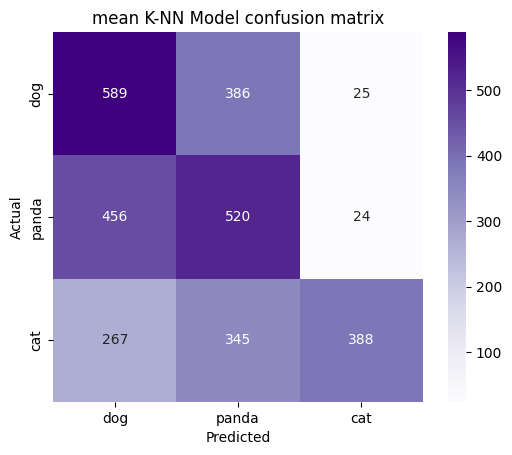

<Figure size 640x480 with 0 Axes>

Mean Accuracy: 0.499
Mean f1 Score: 0.5024077598358785


In [16]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns 
mean_acc = sum(accuracyList)/len(accuracyList)

mean_f1 = sum(f1List)/len(f1List)
meanCM = sum(cmList)

ax = plt.axes()
sns.heatmap(meanCM,ax=ax,annot=True,fmt='g',cmap='Purples',square=True)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:grey')
ax.set_title('mean K-NN Model confusion matrix')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()
print(f"Mean Accuracy: {mean_acc}")
print(f"Mean f1 Score: {mean_f1}")
